In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

# Base Metric
from metrics.base.dice_score_coefficient import dsc

# Match
from match import create_match_dict, get_all_matches, optimal_matching, panoptic_counts, calculate_match_quality, PartPQ

# tools
from metrics.tools.connected_components import gpu_connected_components
from metrics.tools.one_hot_encoding import one_hot_encode
from metrics.tools.labelling import label

from typing import List, Optional
import warnings

warnings.filterwarnings("ignore")

In [2]:
def plot_case(pred, gt, num_classes=8):
    """
    Visualize prediction, ground truth, and a detailed confusion visualization using seaborn styling with pastel colors.

    Args:
        pred: Prediction tensor (class indices)
        gt: Ground truth tensor (class indices)
        num_classes: Number of classes (including background)
    """

    # Set seaborn style
    sns.set(style="whitegrid", context="talk")
    plt.rcParams["axes.edgecolor"] = "0.2"
    plt.rcParams["axes.linewidth"] = 1.5

    # Convert tensors to numpy if they aren't already
    pred_np = pred.cpu().numpy() if hasattr(pred, "cpu") else pred
    gt_np = gt.cpu().numpy() if hasattr(gt, "cpu") else gt

    # Define fixed pastel colors for consistent appearance
    background_color = [0.97, 0.97, 0.97, 1]

    # Use VIBGYOR color palette for classes
    pastel_class_colors = [
        background_color,  # Class 0 (background)
        [0.85, 0.41, 0.43, 1.0],  # Class 1 (darker pastel red)
        [0.88, 0.58, 0.40, 1.0],  # Class 2 (darker pastel orange)
        [0.92, 0.77, 0.5, 1.0],  # Class 3 (darker pastel yellow)
        [0.6, 0.75, 0.55, 1.0],  # Class 4 (darker pastel green)
        [0.55, 0.67, 0.83, 1.0],  # Class 5 (darker pastel blue)
        [0.65, 0.5, 0.75, 1.0],  # Class 6 (darker pastel indigo)
        [0.75, 0.55, 0.75, 1.0],  # Class 7 (darker pastel violet)
    ]

    # If num_classes > 7, extend with additional pastel colors
    if num_classes > 7:
        additional_colors = sns.color_palette("pastel", num_classes - 7)
        class_colors = pastel_class_colors + [
            (*color, 1.0) for color in additional_colors
        ]
    else:
        class_colors = pastel_class_colors[:num_classes]

    class_cmap = mcolors.ListedColormap(class_colors)
    class_norm = mcolors.BoundaryNorm(
        boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes
    )

    # Create confusion visualization matrix
    confusion_vis = np.zeros_like(pred_np)

    # Define confusion colors (fixed for all classes)
    tp_color = [0.77, 0.60, 0.43, 1.0]  # Pastel Brown for TP
    fp_color = [0.95, 0.70, 0.80, 1.0]  # Pastel Pink for FP
    fn_color = [0.85, 0.71, 0.85, 1.0]  # Pastel Purple for FN

    # Build confusion colors array
    confusion_colors = np.zeros((3 * num_classes, 4))  # RGBA colors
    confusion_colors[0] = background_color  # Background (True Negatives)

    # Apply these fixed pastel colors to all classes
    for c in range(1, num_classes):
        # Assign colors to TP/FP/FN categories
        confusion_colors[c] = tp_color  # True positives
        confusion_colors[c + num_classes] = fp_color  # False positives
        confusion_colors[c + 2 * num_classes] = fn_color  # False negatives

        # Fill confusion visualization matrix
        tp_mask = (pred_np == c) & (gt_np == c)
        fp_mask = (pred_np == c) & (gt_np != c)
        fn_mask = (pred_np != c) & (gt_np == c)

        confusion_vis[tp_mask] = c
        confusion_vis[fp_mask] = c + num_classes
        confusion_vis[fn_mask] = c + 2 * num_classes

    confusion_cmap = mcolors.ListedColormap(confusion_colors)
    confusion_norm = mcolors.BoundaryNorm(
        boundaries=np.arange(3 * num_classes + 1) - 0.5, ncolors=3 * num_classes
    )

    # Create figure with better spacing and seaborn style
    fig, ax = plt.subplots(1, 2, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.5)

    # Plot prediction, ground truth, and confusion visualization
    im0 = ax[0].imshow(
        pred_np, cmap=class_cmap, norm=class_norm, interpolation="nearest"
    )
    ax[0].set_title("Pred", fontsize=26, pad=15)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])

    im1 = ax[1].imshow(gt_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[1].set_title("GT", fontsize=26, pad=15)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])

    # Add borders around the plots
    for a in ax:
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_color("#dddddd")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)  # Readjust after tight_layout

    plt.show()

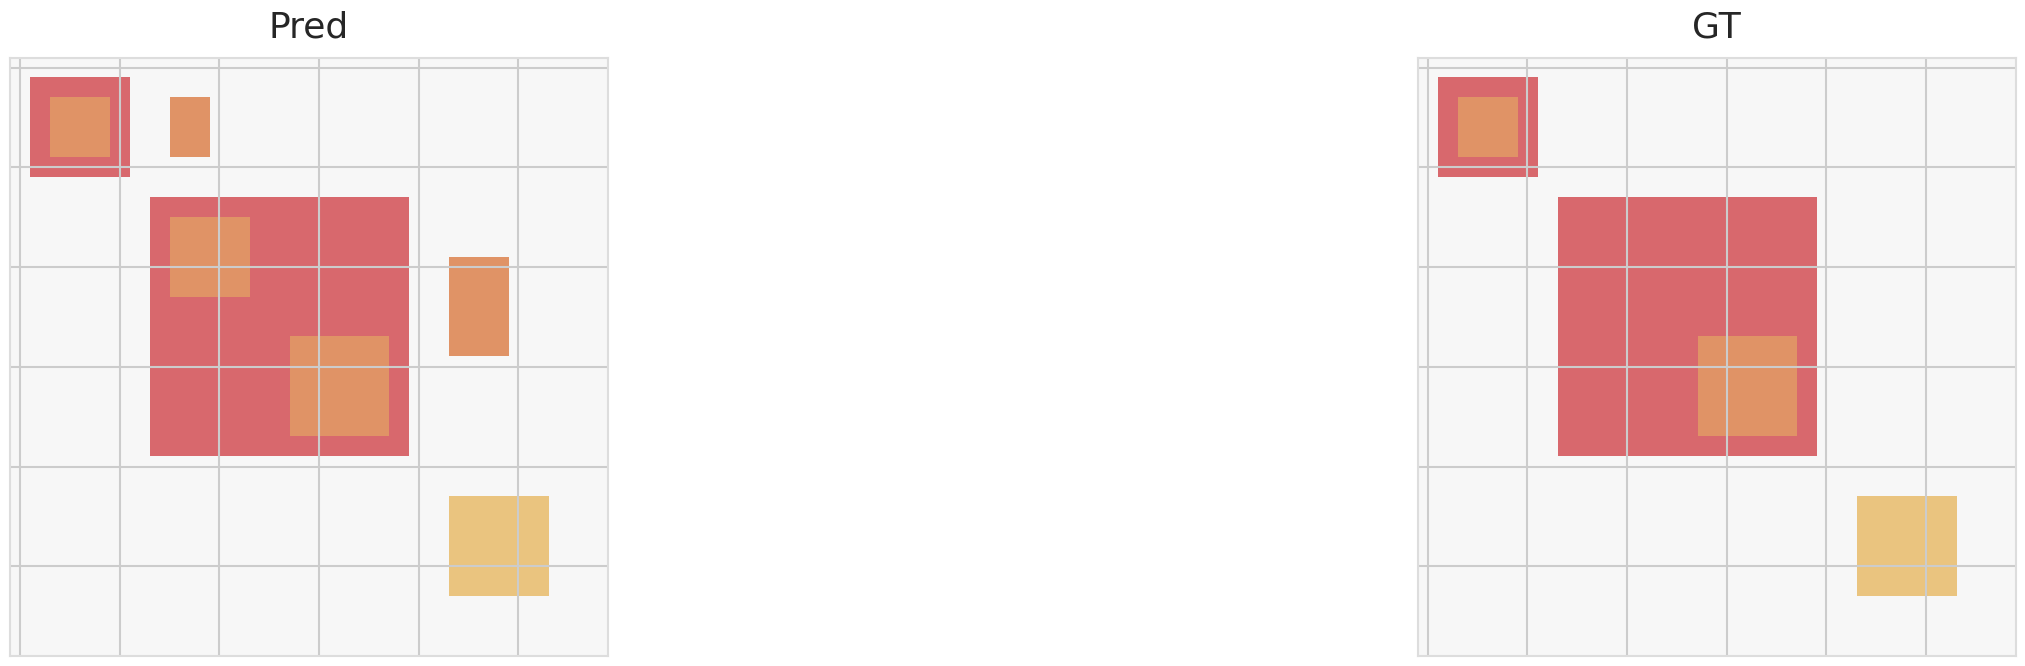

In [3]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

pred[1:6, 1:6] = 1 
pred[2:5, 2:5] = 2
pred[2:5, 8:10] = 2
pred[7:20, 7:20] = 1
pred[8:12, 8:12] = 2
pred[14:19, 14:19] = 2
pred[10:15, 22:25] = 2
pred[22:27, 22:27] = 3

gt[1:6, 1:6] = 1 
gt[2:5, 2:5] = 2
gt[7:20, 7:20] = 1
gt[14:19, 14:19] = 2
gt[22:27, 22:27] = 3

plot_case(pred, gt, num_classes=4)

In [4]:
pred_one_hot_cc = label(pred, 4)
gt_one_hot_cc = label(gt, 4)

In [5]:
panoptic_cls_list = [1, 3]
part_cls_list = [2]

In [6]:
# Assume the necessary functions (create_match_dict, get_all_matches, optimal_matching,
# panoptic_counts, calculate_match_quality, PartPQ) and variables
# (pred_one_hot_cc, gt_one_hot_cc, dsc, panoptic_cls_list, part_cls_list)
# are defined elsewhere, likely corresponding to the code in paste-2.txt.

# Using more descriptive names for clarity
predicted_instance_labels = pred_one_hot_cc
ground_truth_instance_labels = gt_one_hot_cc
dice_metric_function = dsc # Assuming 'dsc' refers to the Dice Score Coefficient metric/function
panoptic_class_indices = panoptic_cls_list
part_class_indices = part_cls_list

# Create match dictionary between predicted and ground truth components
# This dictionary contains panoptic overlaps and collective part scores.
component_match_dictionary = create_match_dict(
    predicted_instance_labels,
    ground_truth_instance_labels,
    dice_metric_function,
    panoptic_class_indices,
    part_class_indices
)

print("=" * 80)
print("COMPONENT MATCHING RESULTS")
print("=" * 80)

# Process results for each semantic class
# Store optimal matches (potentially including part scores) for each class
optimal_matches_per_class = {}

for class_index, matches_for_current_class in component_match_dictionary.items():
    # Ensure we only process panoptic classes in this primary loop if that's the intent
    # Or process all if m_dict contains all relevant classes for matching.
    # Based on the original code, it seems intended to process all classes in m_dict here.
    print(f"\nCLASS {class_index} ANALYSIS:")
    print("-" * 50)

    # Get all candidate panoptic matches and collective part scores for this class
    candidate_panoptic_matches, candidate_part_matches = get_all_matches(matches_for_current_class)

    # Print potential panoptic matches (including FPs and FNs)
    print(f"\nCANDIDATE PANOPTIC MATCHES (Class {class_index}):")
    if candidate_panoptic_matches:
        processed_pairs = set() # Keep track of pairs to avoid double printing FP/FN messages if redundant
        has_matches = False
        for predicted_id, ground_truth_id, match_score in candidate_panoptic_matches:
            pair = (predicted_id, ground_truth_id)
            if pair in processed_pairs:
                continue

            if predicted_id is None:
                print(f"  MISSED: Ground Truth component {ground_truth_id} was not detected (False Negative)")
            elif ground_truth_id is None:
                print(f"  EXTRA: Predicted component {predicted_id} has no corresponding ground truth (False Positive)")
            else:
                match_quality_description = "Good" if match_score > 0.7 else "Poor"
                print(f"  MATCH: Predicted {predicted_id} <-> Ground Truth {ground_truth_id} | Dice: {match_score:.4f} | Quality: {match_quality_description}")
                has_matches = True
            processed_pairs.add(pair)
        if not has_matches and not any(p is None or g is None for p,g,_ in candidate_panoptic_matches):
             print("  No candidate panoptic matches found, only potential FPs/FNs listed above (if any).")
    else:
        # Check if there are unmatched components in GT or Pred based on the source dict
        gt_ids_in_class = set(matches_for_current_class.get("gt_to_pred", {}).keys())
        pred_ids_in_class = set(matches_for_current_class.get("pred_to_gt", {}).keys())
        if not gt_ids_in_class and not pred_ids_in_class:
            print("  No ground truth or predicted components found for this class.")
        else:
            print("  No overlapping candidate matches found for this class.")
            # Optionally list FNs/FPs explicitly here if needed by iterating gt_to_pred/pred_to_gt

    # Print collective part component scores associated with panoptic pairs
    if candidate_part_matches:
        print(f"\nCOLLECTIVE PART COMPONENT SCORES (Class {class_index}):")
        for predicted_id, ground_truth_id, part_class_index, part_score in candidate_part_matches:
            print(f"  Panoptic Pair (Pred {predicted_id} <-> GT {ground_truth_id}) | Part Class {part_class_index} | Collective Score: {part_score:.4f}")
    # else: # Removed the "None found" message as it might be confusing if there are no parts defined
        # print(f"\nPART COMPONENTS: No part classes defined or no parts found within matched components.")

    # Calculate optimal one-to-one assignment using Hungarian algorithm
    # *** Pass candidate_part_matches here so optimal_matching can append part scores ***
    optimal_assignments_for_class = optimal_matching(candidate_panoptic_matches, candidate_part_matches)
    optimal_matches_per_class[class_index] = optimal_assignments_for_class

    print(f"\nOPTIMAL ASSIGNMENTS (Class {class_index}):")
    if optimal_assignments_for_class:
        for assignment in optimal_assignments_for_class:
            predicted_id = assignment[0]
            ground_truth_id = assignment[1]
            panoptic_score = assignment[2]
            # Check if part scores are included (tuple length is 4)
            if len(assignment) == 4:
                part_scores_dict = assignment[3]
                part_info = f" | Part Scores: {part_scores_dict}" # Or format more nicely
            else:
                part_info = ""
            print(f"  Optimal: Predicted {predicted_id} <-> Ground Truth {ground_truth_id} | Panoptic Score: {panoptic_score:.4f}{part_info}")
    else:
        print("  No optimal matches found for this class (might be only FPs or FNs).")

# Calculate panoptic counts (TP, FP, FN) for precision/recall metrics
print("\n" + "=" * 80)
print("PANOPTIC EVALUATION METRICS")
print("=" * 80)

# Calculate counts using the dedicated function, ensuring it *only* considers panoptic classes
# The 'panoptic_counts' function internally calls create_match_dict/optimal_matching
# specifically for counting TP/FP/FN based on panoptic overlap only.
panoptic_counts_per_class = panoptic_counts(
    predicted_instance_labels,
    ground_truth_instance_labels,
    metric='dsc', # Ensure metric matches
    panoptic_cls_list=panoptic_class_indices,
    part_cls_list=part_class_indices # Pass part list so panoptic_counts knows which classes to *exclude*
)

# Filter results to only include panoptic classes explicitly requested (if needed, panoptic_counts should already do this)
# filtered_panoptic_counts = {
#     class_idx: counts for class_idx, counts in panoptic_counts_per_class.items()
#     if class_idx in panoptic_class_indices
# }
# Using the direct output as panoptic_counts is designed to handle the filtering
filtered_panoptic_counts = panoptic_counts_per_class

print("\nPER-CLASS COUNTS (Panoptic Classes Only):")
print("-" * 50)

total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0

if not filtered_panoptic_counts:
     print("  No panoptic classes found or processed for counts.")
else:
    for class_index, (tp, fp, fn) in filtered_panoptic_counts.items():
        # Redundant check if panoptic_counts already filtered, but safe
        if class_index in panoptic_class_indices:
            print(f"\nCLASS {class_index}:")
            print(f"  True Positives (TP): {tp}")
            print(f"  False Positives (FP): {fp}")
            print(f"  False Negatives (FN): {fn}")
            total_true_positives += tp
            total_false_positives += fp
            total_false_negatives += fn
        # else: # Optional: Indicate skipped classes if panoptic_counts didn't filter perfectly
            # print(f"\nCLASS {class_index}: Skipped (Not a panoptic class)")


print("\nOVERALL COUNTS (Across Panoptic Classes):")
print(f"  Total True Positives: {total_true_positives}")
print(f"  Total False Positives: {total_false_positives}")
print(f"  Total False Negatives: {total_false_negatives}")

# Detailed calculation printout for Part Panoptic Quality (PartPQ)
print("\n================================================================================")
print("PART PQ SCORE CALCULATION DETAILS")
print("================================================================================")

# Calculate class-wise quality scores using the optimal matches *including part scores*
print("\nMATCH QUALITY SCORES (Including Part Components where applicable):")
print("-" * 70)

average_quality_per_class = {}
match_details_per_class = {} # For storing details if needed later

# Iterate through the optimal matches we stored earlier
for class_index, current_optimal_matches in optimal_matches_per_class.items():
    # Only calculate quality contribution for panoptic classes
    if class_index not in panoptic_class_indices:
        continue

    # Calculate average quality for this class using the potentially enriched optimal matches
    # calculate_match_quality handles tuples of length 3 or 4 correctly
    average_match_quality_for_class, individual_match_qualities = calculate_match_quality(current_optimal_matches)

    average_quality_per_class[class_index] = average_match_quality_for_class
    match_details_per_class[class_index] = [] # Initialize details storage

    print(f"\nCLASS {class_index} Match Quality Details:")

    if not current_optimal_matches:
        print(f"  No optimal matches found - Average Match Quality Contribution = 0.0")
        continue

    # Print details for each optimally matched pair based on stored data
    for i, current_match_tuple in enumerate(current_optimal_matches):
        quality_score_for_this_match = individual_match_qualities[i]
        predicted_component_id = current_match_tuple[0]
        ground_truth_component_id = current_match_tuple[1]
        current_panoptic_score = current_match_tuple[2]

        match_info_dict = {
            'predicted_id': predicted_component_id,
            'ground_truth_id': ground_truth_component_id,
            'panoptic_score': current_panoptic_score,
            'match_quality': quality_score_for_this_match
        }

        print(f"  Match {i+1}: Predicted {predicted_component_id} <-> Ground Truth {ground_truth_component_id}")
        print(f"    - Panoptic Component Score: {current_panoptic_score:.4f}")

        # Check if part scores are included in the tuple
        if len(current_match_tuple) == 4:
            current_part_scores = current_match_tuple[3]
            match_info_dict['part_scores'] = current_part_scores
            scores_for_quality_calculation = [current_panoptic_score] + list(current_part_scores.values())

            if current_part_scores:
                 print(f"    - Part Component Scores:")
                 for part_class_index, part_component_score in current_part_scores.items():
                     print(f"      - Part Class {part_class_index}: {part_component_score:.4f}")
                 print(f"    - Calculated Match Quality: {quality_score_for_this_match:.4f} (Average of {len(scores_for_quality_calculation)} scores)")
            else:
                 print(f"    - No part scores found for this match pair, though parts were checked.")
                 print(f"    - Calculated Match Quality: {quality_score_for_this_match:.4f} (Based on panoptic score only)")

        else: # Match tuple only had panoptic info
            print(f"    - No part component scores included in this match data.")
            print(f"    - Calculated Match Quality: {quality_score_for_this_match:.4f} (Based on panoptic score only)")

        match_details_per_class[class_index].append(match_info_dict)

    # Print the average quality for the class
    print(f"  -> Class {class_index} Average Match Quality (for TP): {average_match_quality_for_class:.4f}")


# [... Previous sections of the refactored code remain the same ...]
# - Variable renaming
# - Emoji removal
# - Passing part_matches to optimal_matching
# - Calculating panoptic counts (TP, FP, FN)
# - Calculating and printing average_quality_per_class and individual match details

# Calculate the final Part PQ score based on the sum of *average* class qualities
print("\n================================================================================")
print("FINAL PART PQ CALCULATION")
print("================================================================================")

# Numerator: Sum of the *average* quality scores calculated for each panoptic class's matches.
# This uses the 'mean_quality' returned by calculate_match_quality for each class.
part_pq_numerator = sum(average_quality_per_class.values()) # Sum the mean scores stored previously

# Denominator: Total True Positives + Total False Positives + Total False Negatives
# Using the counts calculated earlier for panoptic classes only.
part_pq_denominator = total_true_positives + total_false_positives + total_false_negatives

# Print detailed numerator calculation
print("\nNUMERATOR CALCULATION (Sum of Average Class Quality Scores):")
print("-" * 70)
if average_quality_per_class:
    for class_index, average_score in average_quality_per_class.items():
        # Ensure only panoptic classes contribute (already filtered when populating the dict)
        if class_index in panoptic_class_indices:
             print(f"  Class {class_index} Average Quality: {average_score:.4f}")
else:
    print("  No panoptic classes had matches to contribute to the quality score.")
print(f"\n  Total Numerator (Sum of Average Class Qualities): {part_pq_numerator:.4f}")

# Print detailed denominator calculation
print("\nDENOMINATOR CALCULATION (Total TPs + FPs + FNs across Panoptic Classes):")
print("-" * 70)
print(f"  Total True Positives (TPs): {total_true_positives}")
print(f"  Total False Positives (FPs): {total_false_positives}")
print(f"  Total False Negatives (FNs): {total_false_negatives}")
print(f"\n  Total Denominator: {part_pq_denominator}")

# Calculate and print the final Part PQ score
# Avoid division by zero
final_part_pq_score = part_pq_numerator / part_pq_denominator if part_pq_denominator > 0 else 0.0

print("\n================================================================================")
print(f"FINAL PART PQ SCORE: {final_part_pq_score:.4f}")
print("================================================================================")

# Print a summary of the calculation components based on the implementation
print("\nCALCULATION SUMMARY (Based on Implementation):")
print(f"  PartPQ = Numerator / Denominator")
print(f"         = (Sum of Average Quality Scores per Panoptic Class) / (Total TPs + Total FPs + Total FNs)")
print(f"         = {part_pq_numerator:.4f} / {part_pq_denominator}")
print(f"         = {final_part_pq_score:.4f}")

# Compare with direct calculation using the PartPQ function for verification
# Assuming PartPQ function exists and implements the same logic (sum of avg class qualities / (TP+FP+FN))
direct_part_pq_verification = PartPQ(
    predicted_instance_labels,
    ground_truth_instance_labels,
    metric='dsc', # Make sure this matches the metric used throughout
    panoptic_cls_list=panoptic_class_indices,
    part_cls_list=part_class_indices
)
print(f"\nDirect PartPQ function calculation (for verification): {direct_part_pq_verification:.4f}")
# Small differences might still occur due to floating point precision.

print("\n================================================================================")


COMPONENT MATCHING RESULTS

CLASS 1 ANALYSIS:
--------------------------------------------------

CANDIDATE PANOPTIC MATCHES (Class 1):
  MATCH: Predicted 1 <-> Ground Truth 1 | Dice: 1.0000 | Quality: Good
  MATCH: Predicted 2 <-> Ground Truth 2 | Dice: 0.9412 | Quality: Good

COLLECTIVE PART COMPONENT SCORES (Class 1):
  Panoptic Pair (Pred 1 <-> GT 1) | Part Class 2 | Collective Score: 1.0000
  Panoptic Pair (Pred 2 <-> GT 2) | Part Class 2 | Collective Score: 0.7576

OPTIMAL ASSIGNMENTS (Class 1):
  Optimal: Predicted 1 <-> Ground Truth 1 | Panoptic Score: 1.0000 | Part Scores: {2: 1.0}
  Optimal: Predicted 2 <-> Ground Truth 2 | Panoptic Score: 0.9412 | Part Scores: {2: 0.7575757503509521}

CLASS 3 ANALYSIS:
--------------------------------------------------

CANDIDATE PANOPTIC MATCHES (Class 3):
  MATCH: Predicted 1 <-> Ground Truth 1 | Dice: 1.0000 | Quality: Good

OPTIMAL ASSIGNMENTS (Class 3):
  Optimal: Predicted 1 <-> Ground Truth 1 | Panoptic Score: 1.0000

PANOPTIC EVALUAT